In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
sns.set_style('white')
sns.set(rc={'figure.figsize': (11, 4)})

## 1.

In [3]:
# dummy dataset
DF_ORIG = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv', index_col='timestamp', parse_dates=True)
# DF_ORIG = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_IBM.csv', index_col='timestamp', parse_dates=True)

In [4]:
DF_ORIG.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


In [5]:
DF_ORIG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15831 entries, 2015-02-26 21:42:53 to 2015-04-22 20:52:53
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   15831 non-null  int64
dtypes: int64(1)
memory usage: 247.4 KB


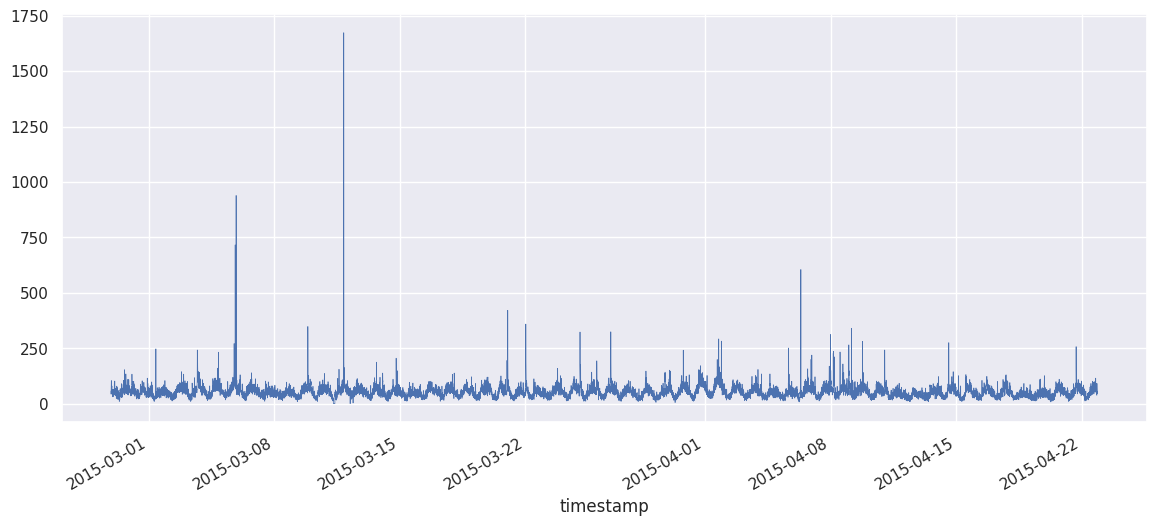

In [6]:
plt.figure(figsize=(14, 6))
DF_ORIG['value'].plot(linewidth=0.5)
plt.show()

In [7]:
DF_ORIG['date'] = pd.to_datetime(DF_ORIG.index).date

In [8]:
DF_ORIG['h'] = pd.to_datetime(DF_ORIG.index).hour

In [9]:
DF_ORIG.head(1)

,value,date,h
timestamp,,,
2015-02-26 21:42:53,57,2015-02-26,21


In [10]:
df_date = DF_ORIG.groupby('date').sum()

### TODO: chance that i must drop outliers

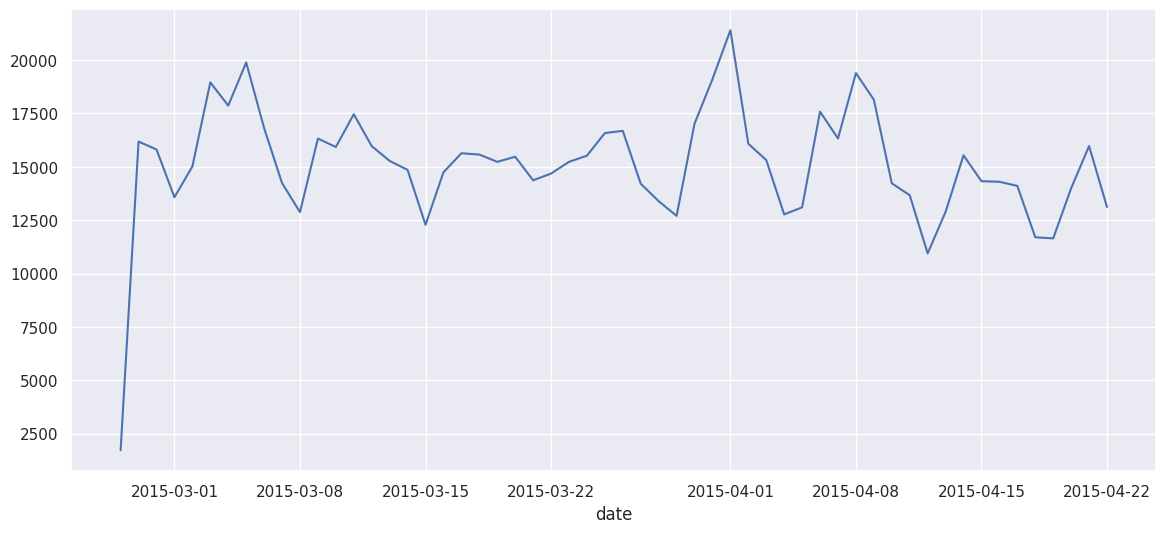

In [11]:
plt.figure(figsize=(14, 6))
df_date['value'].plot()
plt.show()

In [12]:
df_h = DF_ORIG.groupby(pd.Grouper(freq='1h')).sum(numeric_only=True)
df_h.head(5)

,value,h
timestamp,,
2015-02-26 21:00:00,219,84
2015-02-26 22:00:00,931,264
2015-02-26 23:00:00,568,276
2015-02-27 00:00:00,516,0
2015-02-27 01:00:00,574,12


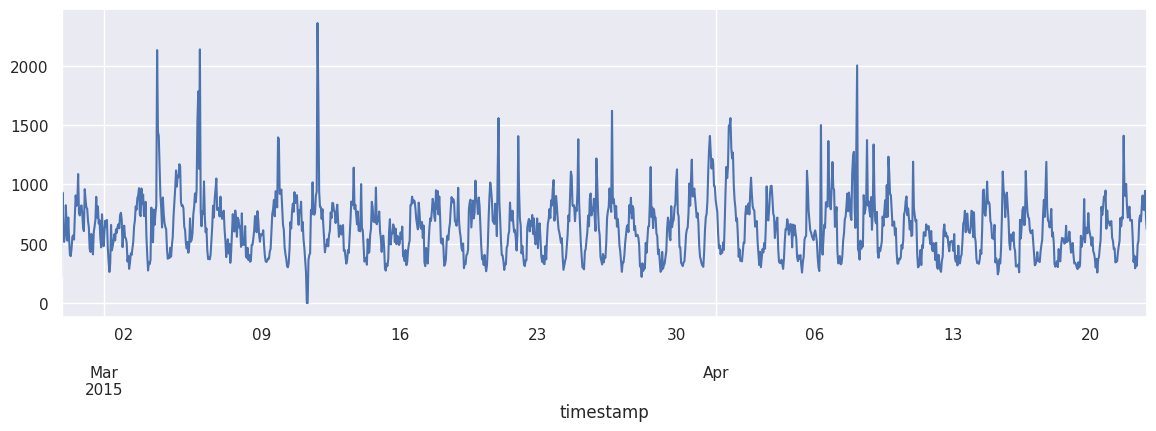

In [13]:
plt.figure(figsize=(14, 4))
df_h['value'].plot()
plt.show()

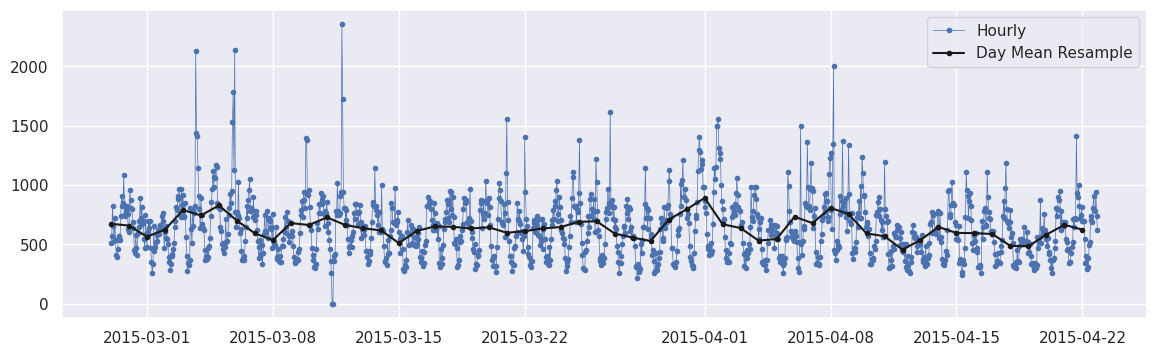

In [14]:
start, end = '2015-02-27', '2015-04-22'

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_h.loc[start:end, 'value'],marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(df_h.resample('D').mean().loc[start:end, 'value'], marker='o',
        markersize=3, linestyle='-', label='Day Mean Resample', color='k')
ax.legend();

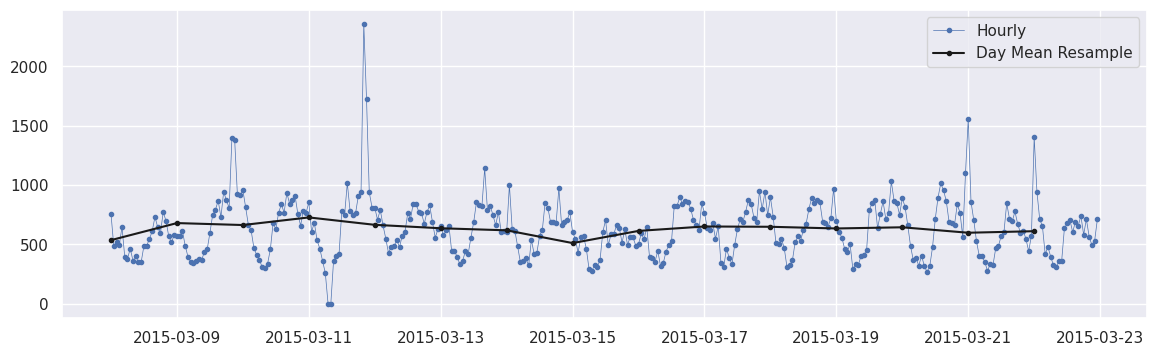

In [15]:
start, end = '2015-03-08', '2015-03-22'

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_h.loc[start:end, 'value'],marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(df_h.resample('D').mean().loc[start:end, 'value'], marker='o', markersize=3, linestyle='-', label='Day Mean Resample', color='k')
ax.legend();

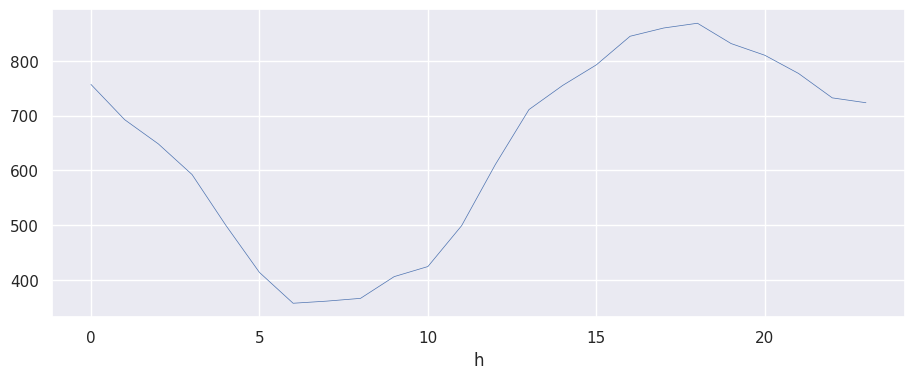

In [16]:
df_h.h = pd.to_datetime(df_h.index).hour

df_h_h = df_h.groupby('h').mean()

df_h_h['value'].plot(linewidth=0.5)
plt.show()

## 2.

In [17]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 12.4 MB/s eta 0:00:00


### TODO: simplify imports

In [18]:
import warnings
import sktime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tools.sm_exceptions import ConvergenceWarning

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [19]:
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

%matplotlib inline

In [20]:
df_h_copy = df_h.value.astype('float')

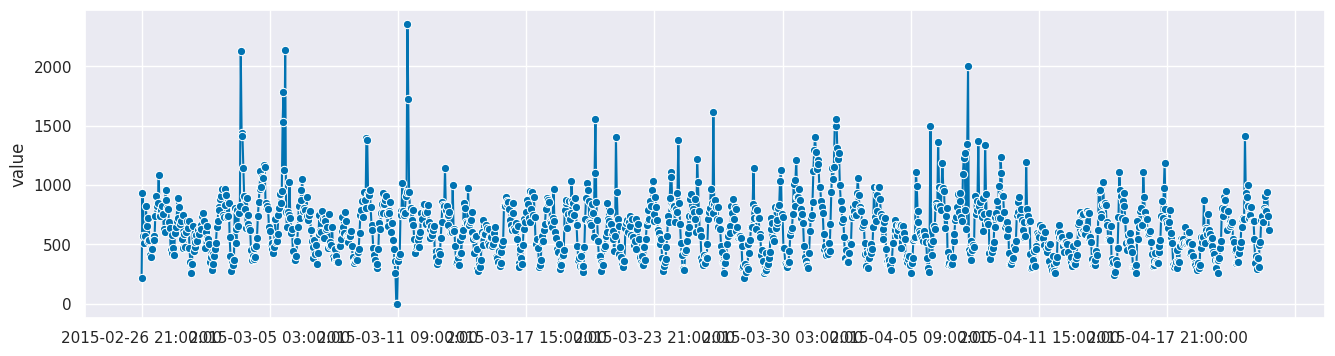

In [21]:
sktime.utils.plotting.plot_series(df_h_copy)
plt.show()

In [22]:
X_train, X_test = temporal_train_test_split(df_h_copy, test_size=int(df_h_copy.size * 0.4))

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

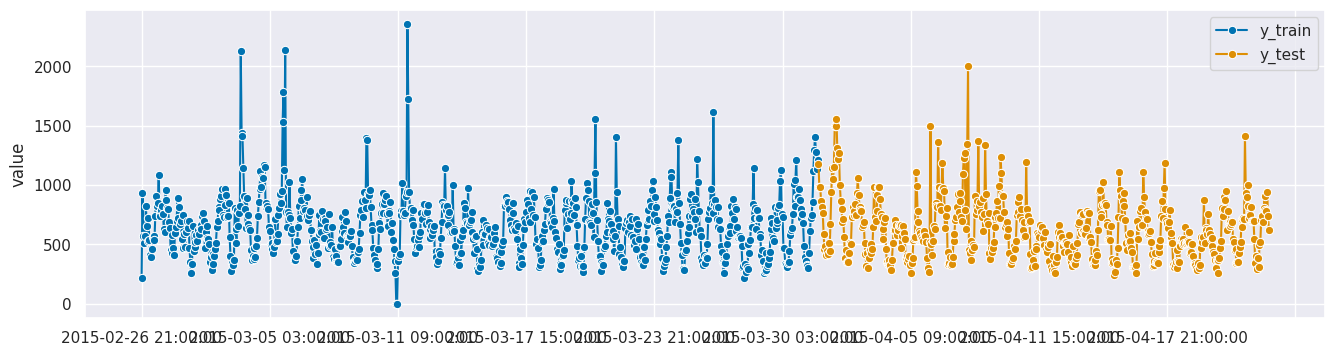

In [23]:
sktime.utils.plotting.plot_series(X_train, X_test, labels=['y_train', 'y_test'])

In [24]:
# X_train.to_csv("X_train.csv", index_label="timestamp")
# X_test.to_csv("X_test.csv", index_label="timestamp")
# df_h.to_csv("df_h.csv", index_label="timestamp")

### TODO: change these values

In [25]:
for i in range(len(X_train)):
    if X_train[i] > 1400:
        X_train[i] = 1400
    if X_train[i] < 250:
        X_train[i] = 250

In [26]:
FH = ForecastingHorizon(X_test.index, is_relative=False)

In [27]:
FORECASTER = NaiveForecaster(strategy="mean", sp=24)

In [28]:
FORECASTER.fit(X_train)

NaiveForecaster(sp=24, strategy='mean')

In [29]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

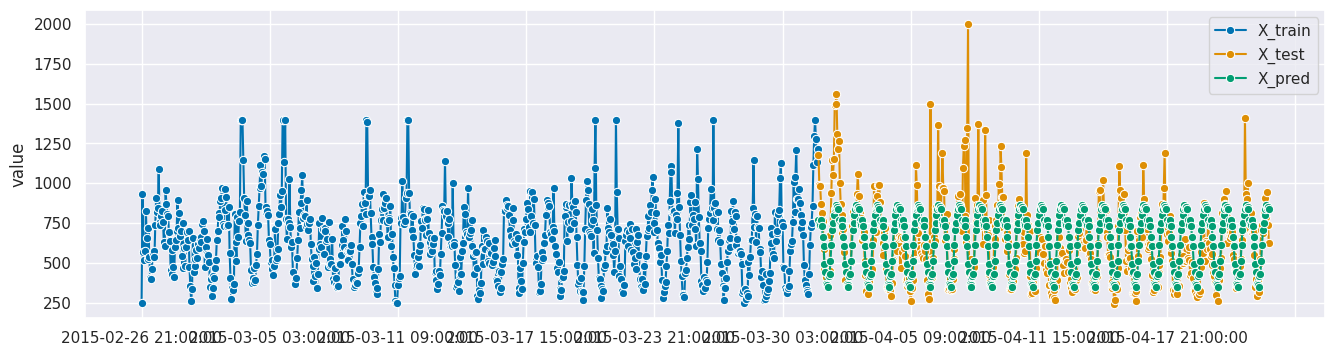

In [30]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])

In [31]:
smape(X_pred.values, X_test.values)

0.19435296633771768

In [32]:
FORECASTER = NaiveForecaster(strategy="mean", sp=24 * 7)

In [33]:
FORECASTER.fit(X_train)

NaiveForecaster(sp=168, strategy='mean')

In [34]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

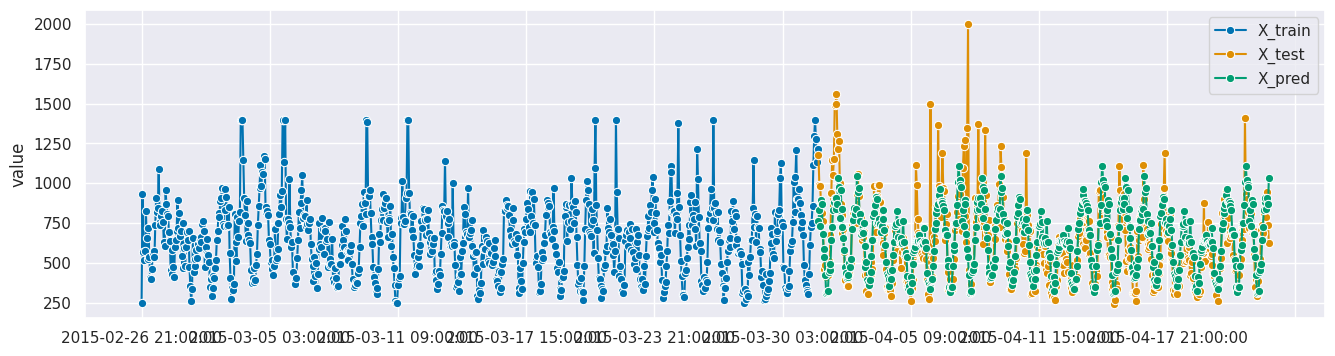

In [35]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])

In [36]:
smape(X_pred.values, X_test.values)

0.17617166526164874

In [37]:
FORECASTER = ThetaForecaster(sp=24 * 7)

In [38]:
FORECASTER.fit(X_train, fh=FH)

ThetaForecaster(sp=168)

In [39]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

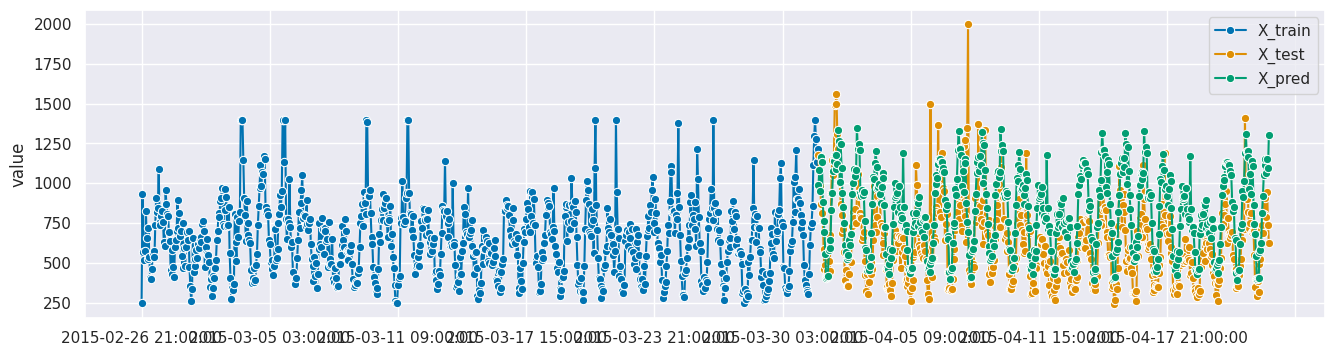

In [40]:
plot_series(X_train, X_test, X_pred, labels=["X_train", "X_test", "X_pred"])

In [41]:
smape(X_pred.values, X_test.values)

0.3238822968806311

In [42]:
FORECASTER = ExponentialSmoothing(trend="mul", seasonal="add", sp=24 * 7, method='ls')

In [43]:
FORECASTER.fit(X_train)

ExponentialSmoothing(method='ls', seasonal='add', sp=168, trend='mul')

In [44]:
y_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

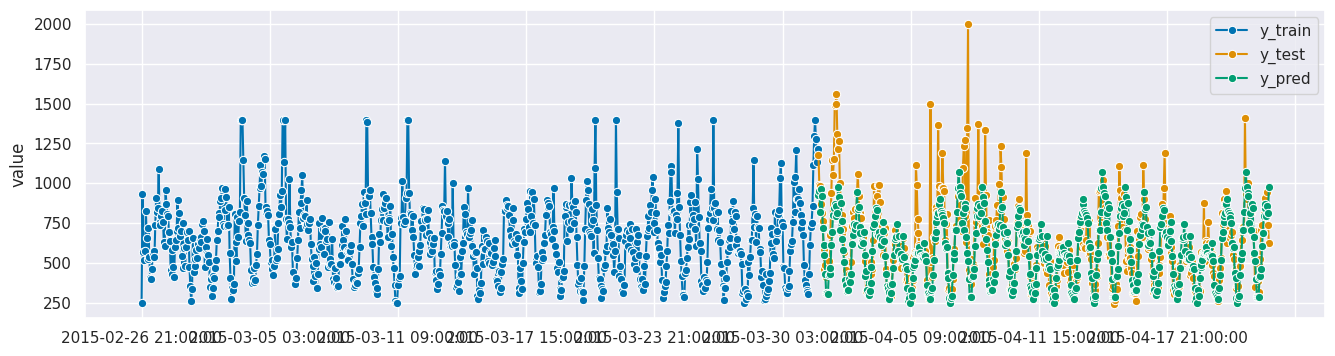

In [45]:
plot_series(X_train, X_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [46]:
smape(y_pred.values, X_test.values)

0.16779149125401127

In [47]:
ses = ExponentialSmoothing()

FORECASTER = TransformedTargetForecaster(
                steps=[
                ("deseasonalize1", Deseasonalizer(model="multiplicative", sp=24)),
                ("deseasonalize2", Deseasonalizer(model="multiplicative", sp=24*7)),
                ("forecaster", ses),
                ])
FORECASTER.fit(X_train)

TransformedTargetForecaster(steps=[('deseasonalize1',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=24)),
                                   ('deseasonalize2',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=168)),
                                   ('forecaster', ExponentialSmoothing())])

In [48]:
X_pred = FORECASTER.predict(FH)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

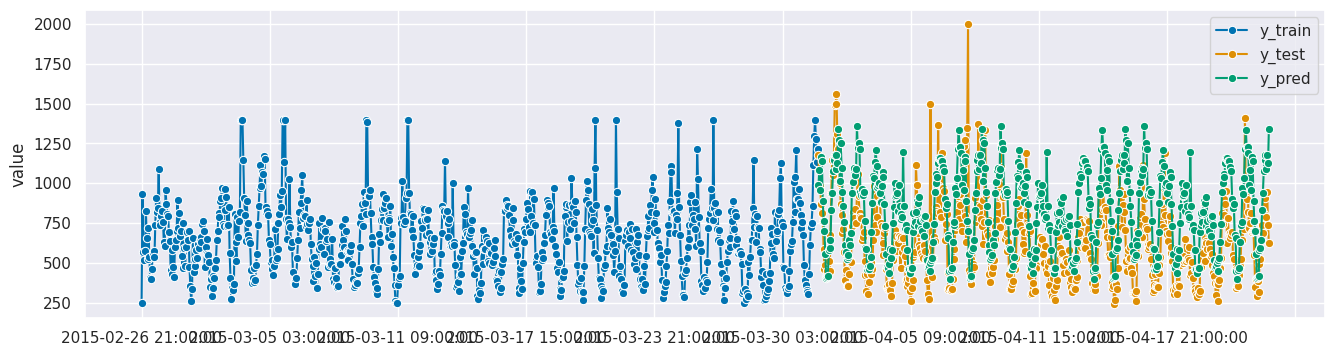

In [49]:
plot_series(X_train, X_test, X_pred, labels=["y_train", "y_test", "y_pred"])

In [50]:
smape(y_pred.values, X_test.values)

0.16779149125401127

## 3.

In [51]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


In [67]:
# except:
#     !pip install sktime --user
#     !pip install pmdarima
#     !pip install statsmodels
#     !pip install prophet

import pmdarima as pm
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [53]:
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

In [54]:
ROLLING_MEAN = X_train.rolling(window = 24).mean()
ROLLING_STD  = X_train.rolling(window = 24).std()

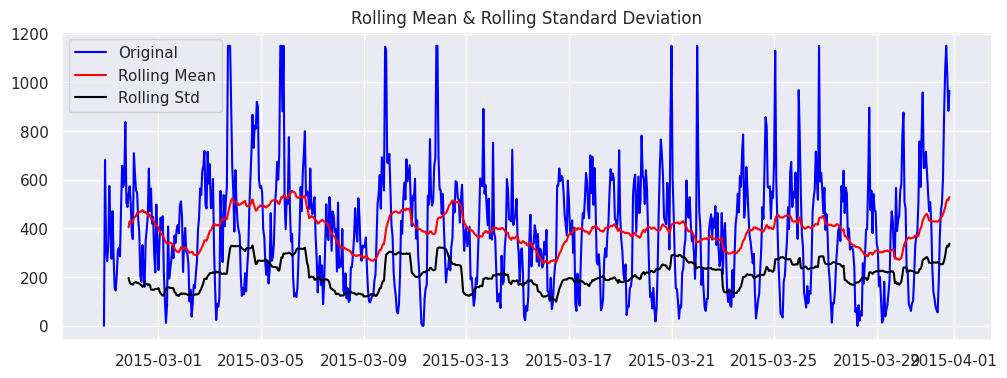

In [55]:
plt.figure(figsize=(12,4), dpi=100)

plt.plot(X_train - X_train[0],      color = 'blue',  label = 'Original')
plt.plot(ROLLING_MEAN - X_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(ROLLING_STD,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [56]:
P_THRESHOLD = 0.05

In [57]:
def check_ADF(y, p_threshold):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')
    return result

In [58]:
check_ADF(X_train, P_THRESHOLD);

ADF Statistic: -3.2710
p-value: 0.0162
Critical Values:
	1%: -3.4389, outperformed
	5%: -2.8653, 
	10%: -2.5688, 
Result: The series is not stationary


In [59]:
X_diff = X_train[:].diff(1).dropna()
rolling_mean = X_diff.rolling(window = 24).mean()
rolling_std  = X_diff.rolling(window = 24).std()

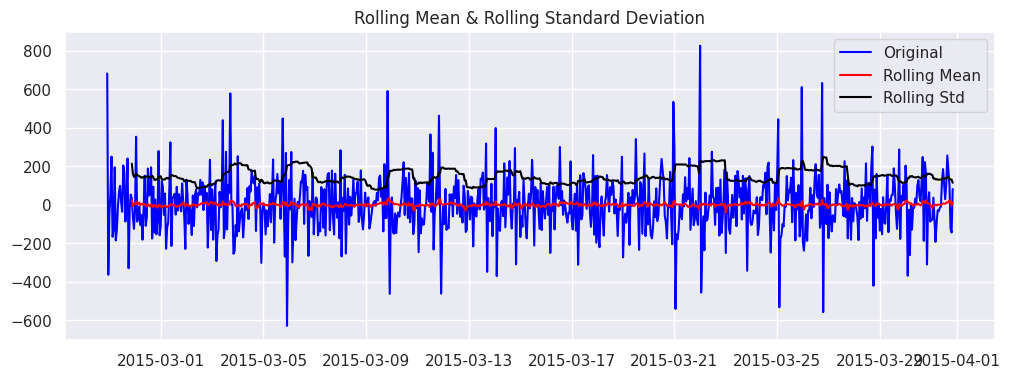

In [60]:
plt.figure(figsize=(12,4), dpi=100)

plt.plot(X_diff, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [61]:
result = check_ADF(X_diff, P_THRESHOLD)

ADF Statistic: -16.3086
p-value: 0.0000
Critical Values:
	1%: -3.4389, 
	5%: -2.8653, 
	10%: -2.5688, 
Result: The series is not stationary


In [62]:
SEASON = 24

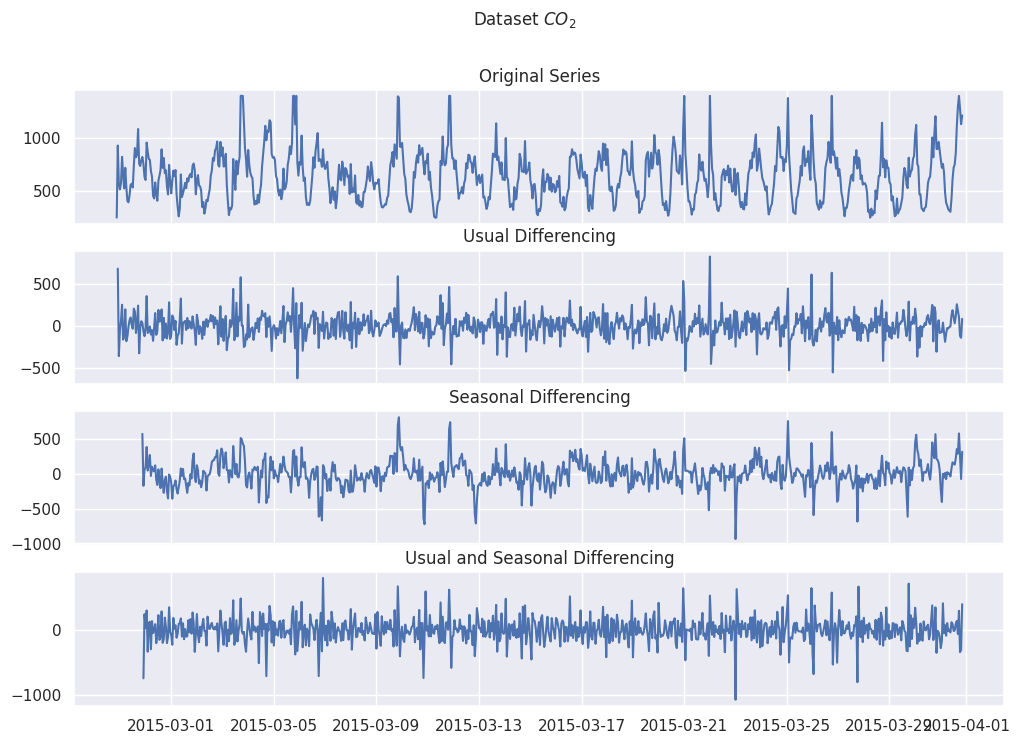

In [63]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(X_train[:])
axes[0].set_title('Original Series')
# plt.show()

# Usual Differencing
axes[1].plot(X_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(X_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(X_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()

In [64]:
X_sdif = X_train[:].diff(1).diff(SEASON).dropna()

In [66]:
results = check_ADF(X_sdif, P_THRESHOLD);

ADF Statistic: -10.2063
p-value: 0.0000
Critical Values:
	1%: -3.4391, 
	5%: -2.8654, 
	10%: -2.5688, 
Result: The series is not stationary


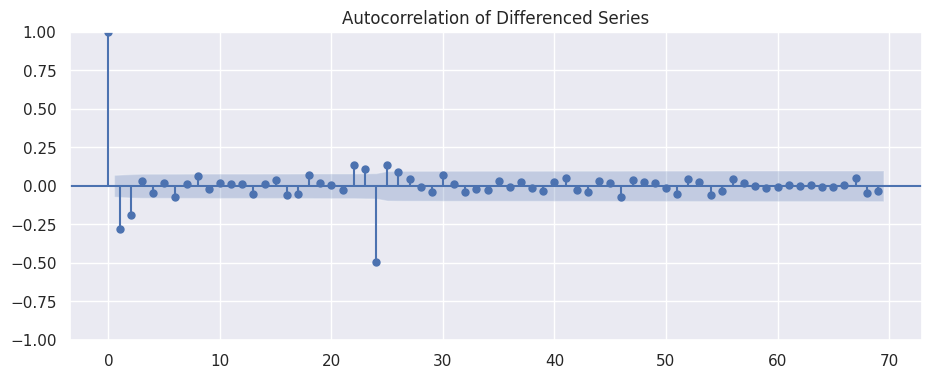

In [69]:
plot_acf(X_sdif, title='Autocorrelation of Differenced Series', lags=np.arange(70) )
plt.show()

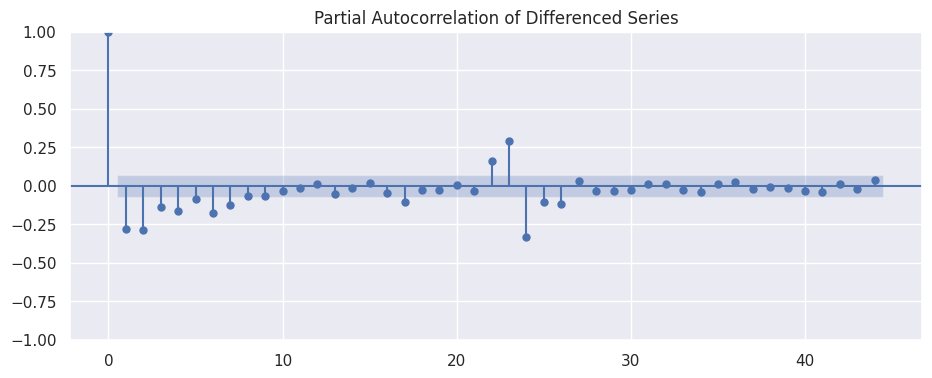

In [70]:
plot_pacf(X_sdif, title='Partial Autocorrelation of Differenced Series', method='ywm', lags=np.arange(45));plt.show()
plt.show();

In [71]:
forecaster = SARIMAX(order= (7, 0, 0), seasonal_order=(3, 1, 0, SEASON))
forecaster.fit(X_train)
print(forecaster.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  792
Model:             SARIMAX(7, 0, 0)x(3, 1, 0, 24)   Log Likelihood               -4869.429
Date:                            Sat, 06 Jan 2024   AIC                           9762.858
Time:                                    12:39:34   BIC                           9818.584
Sample:                                02-26-2015   HQIC                          9784.307
                                     - 03-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9507      5.523      0.353      0.724      -8.874      12.775
ar.L1          0.4898      0.030   

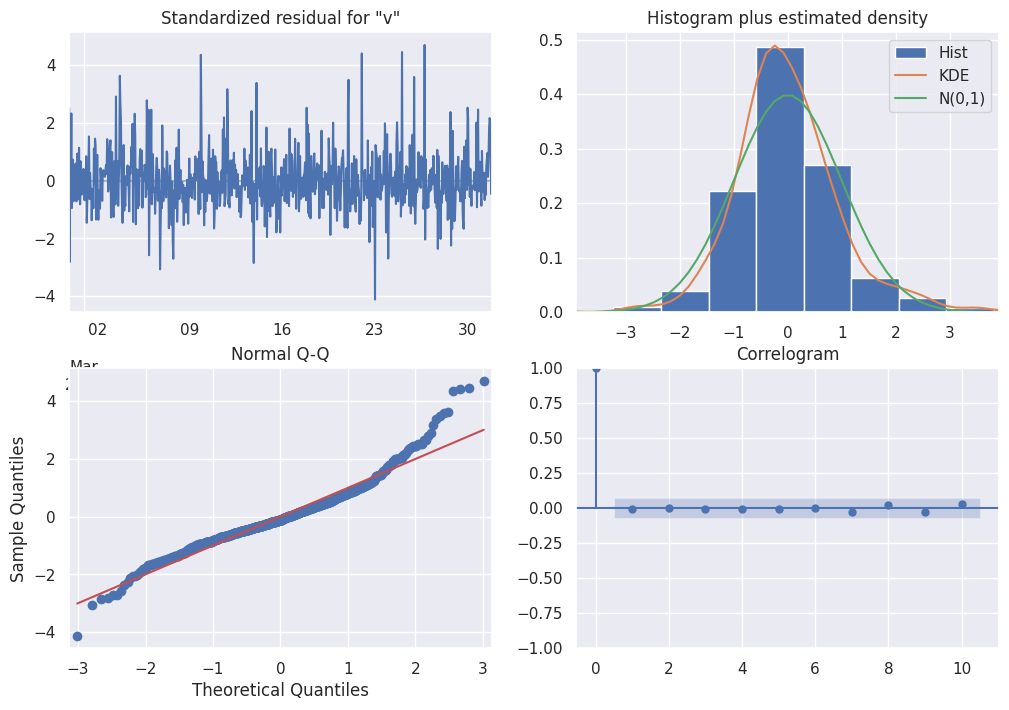

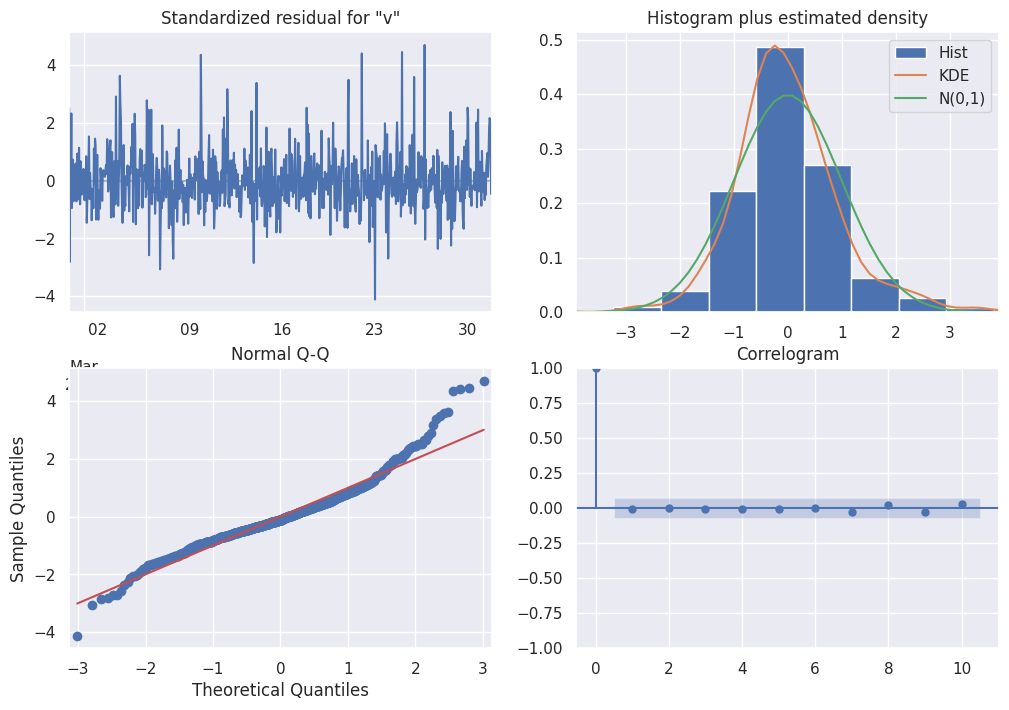

In [72]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8))

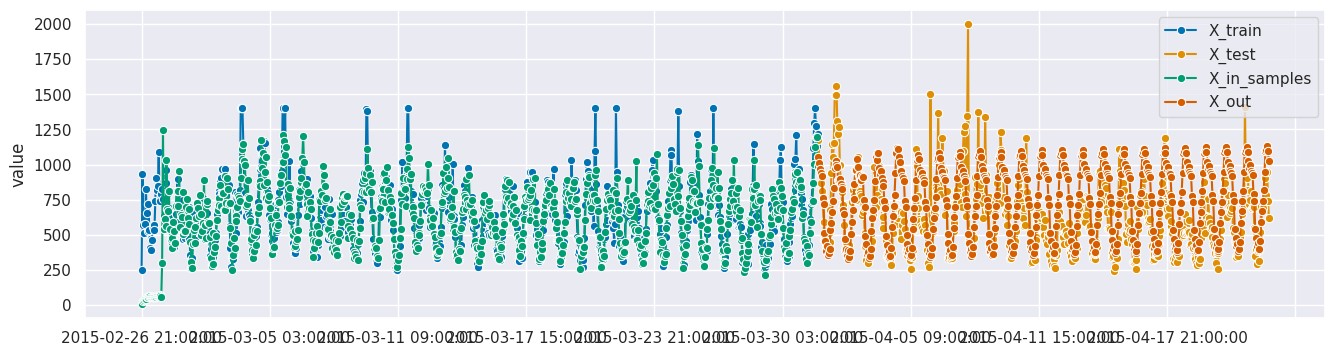

In [76]:
fhin = ForecastingHorizon(X_train.index[1:], is_relative=False)
X_in_samples = forecaster.predict(fhin)

X_out = forecaster.predict(FH)

plot_series(X_train, X_test, X_in_samples, X_out, labels=["X_train", "X_test", "X_in_samples", "X_out"])
plt.show()

In [77]:
smape(X_out.values, X_test.values)

0.2663719600483285

In [78]:
model = AutoARIMA(start_p=1,
                  d=1,
                  start_q=0,
                  max_p=5,
                  max_q=5,
                  seasonal=True,
                  start_P=0,
                  start_Q=0,
                  D=1,
                  sp=24,
                  max_order = 5,
                  trace  = True,
                  stepwise = True,
                  n_jobs = 1,
                  error_action='ignore',
                  suppress_warnings=True)

In [ ]:
model.fit(X_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[24] intercept   : AIC=10238.377, Time=1.09 sec
 ARIMA(0,1,0)(0,1,0)[24] intercept   : AIC=10300.561, Time=0.49 sec
 ARIMA(1,1,0)(1,1,0)[24] intercept   : AIC=10001.640, Time=12.60 sec
 ARIMA(0,1,1)(0,1,1)[24] intercept   : AIC=inf, Time=19.44 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=10298.563, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[24] intercept   : AIC=9932.272, Time=20.61 sec
 ARIMA(1,1,0)(2,1,1)[24] intercept   : AIC=inf, Time=77.27 sec
 ARIMA(1,1,0)(1,1,1)[24] intercept   : AIC=inf, Time=14.01 sec
 ARIMA(0,1,0)(2,1,0)[24] intercept   : AIC=10002.453, Time=19.56 sec
 ARIMA(2,1,0)(2,1,0)[24] intercept   : AIC=9868.022, Time=28.67 sec
 ARIMA(2,1,0)(1,1,0)[24] intercept   : AIC=9939.553, Time=17.90 sec
 ARIMA(2,1,0)(2,1,1)[24] intercept   : AIC=inf, Time=73.13 sec
 ARIMA(2,1,0)(1,1,1)[24] intercept   : AIC=inf, Time=37.45 sec
 ARIMA(3,1,0)(2,1,0)[24] intercept   : AIC=9864.434, Time=48.53 sec
 ARIMA(3,1,0)(1,1,0)[24] int

In [ ]:
model.summary()

In [ ]:
fhin = ForecastingHorizon(X_train.index[1:], is_relative=False)
X_in_samples = model.predict(fhin)

X_out = model.predict(FH)

plot_series(X_train, X_test, X_in_samples, X_out, labels=["X_train", "X_test", "X_in_samples", "X_out"])

## 4.

## 5.

In [ ]:
smape(X_out.values, X_test.values)